# Imports

In [1]:
# What version of Python do you have?
import sys
import pandas as pd
import numpy as np
import math
from PIL import Image, ImageOps
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from skimage import exposure

from tqdm import tqdm

import gc
import copy
import cv2
import keras.backend as K

# import sklearn as sk
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import plotly.graph_objects as go

from os import walk

In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize, ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import get_file, plot_model, to_categorical

In [3]:
#IMPORT ALL LAYERS AND KERAS/TENSORFLOW PARAMS
from tensorflow.keras import layers
from tensorflow.keras.layers import StringLookup, CategoryEncoding, GlobalMaxPooling2D, Rescaling, SeparableConv2D, BatchNormalization, Conv2D, Conv2DTranspose, MaxPool2D, Activation, Dropout, Dense, Flatten, Input, Concatenate, Add, AveragePooling2D, GlobalAveragePooling2D, AveragePooling1D, Reshape, UpSampling2D, Convolution2DTranspose
from tensorflow.keras.models import Sequential, Model
from keras.activations import relu,leaky_relu
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.regularizers import l2, l1, l1_l2
import keras_ocr 

In [4]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, log_loss, confusion_matrix, f1_score, classification_report
from sklearn.metrics import mean_absolute_error

In [5]:
print(f"Python {sys.version}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"Pandas {pd.__version__}")
print(f"Keras Version: {np.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Tensor Flow Version: 2.10.0-dev20220413
Keras Version: 2.10.0
Pandas 1.3.5
Keras Version: 1.22.3

GPU is available


In [6]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
!nvidia-smi

Tue Aug  2 17:43:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.59       Driver Version: 516.59       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   51C    P8    39W / 350W |   1536MiB / 12288MiB |     21%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
sys.path.append('../E-CNN-classifier-main/libs')
import ds_layer #Dempster-Shafer layer
import utility_layer_train #Utility layer for training
import utility_layer_test #Utility layer for training
import AU_imprecision #Metric average utility for set-valued classification

## Paths

In [9]:
#PathForSeverstal

pathTrainImgs = Path('../DB/train_images/')
# pathTrainImgs = Path('../DB/cropped_train_images/')
pathTrainImgsLabels = Path('../DB/train_images_masks/')
# pathTrainImgsLabels = Path('../DB/cropped_train_images_masks/')
# cvsPath = Path('../DB/train.csv')
cvsPath = Path('../DB/cropped_train.csv')

# VIDEOSYSTEMPATH

# vsXpath = Path('../DB/Video-Systems/labelled/db/X/')
# vsYpath = Path('../DB/Video-Systems/labelled/db/Y/')

vsXpath = Path('../DB/Video-Systems/labelled/db/Cropped/X/')
vsYpath = Path('../DB/Video-Systems/labelled/db/Cropped/Y/')

In [10]:
checkpointPath = Path('../Outputs/VideoSystems/CHECKPOINTS/CROPPED-DB/')
graphPath = Path('../Outputs/VideoSystems/GRAPHS/CROPPED-DB/')
pathSavedModel = Path('../Outputs/VideoSystems/MODELS-PB/CROPPED-DB/')
plotpath = Path('../Outputs/VideoSystems/PLTS/CROPPED-DB/')
evalspath = Path('../Outputs/VideoSystems/EVALUATIONS/CROPPED-DB/')

In [11]:
checkpointPath.mkdir(parents=True, exist_ok=True)
graphPath.mkdir(parents=True, exist_ok=True)
pathSavedModel.mkdir(parents=True, exist_ok=True)
plotpath.mkdir(parents=True, exist_ok=True)
evalspath.mkdir(parents=True, exist_ok=True)

## Random Seed

In [12]:
SEED = 42

## Global Variables

In [13]:
# IMAGE_SIZE = [1600,256] #original size
IMAGE_SIZE = [1440,1256] #original size
# IMAGE_SIZE = [1256,1440] #original size
IMAGE_SIZE = [128,256] #original size CROPPED
IMAGE_RESIZE = [256,800]

## Utilities

In [14]:
def printAndSaveGraphs(pathWsave,nameOfModelGraph, history, Metrics, saveit = True, dpi = 300):

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model '+nameOfModelGraph+ ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation-HKonly'], loc='upper left')
    if saveit:
        plt.savefig(Path(pathWsave) / Path(nameOfModelGraph + '_loss.png'),dpi=dpi)
    plt.show()

    for met in Metrics:
        # summarize history for accuracy
        plt.plot(history.history[met.name])
        plt.plot(history.history['val_'+met.name])
        plt.title('model '+nameOfModelGraph+ met.name)
        plt.ylabel(met.name)
        # plt.plot(history.history[met])
        # plt.plot(history.history['val_'+met])
        # plt.title('model '+nameOfModelGraph+ met)
        # plt.ylabel(met)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        if saveit:
            plt.savefig(Path(pathWsave) / Path(nameOfModelGraph + met.name + '.png'),dpi=dpi)
            # plt.savefig(Path(pathWsave) / Path(nameOfModelGraph + met + '.png'),dpi=dpi)
        plt.show()

In [15]:
def loadPNGtoArray(paths,basePath, outSize = IMAGE_SIZE, resize = True):
    imgs = []
    for p in tqdm(paths):
        p = Path(p)
        # print(p)
        # fullPath = Path(str(basePath) + str(p))
        fullPath = basePath / p
        # print(basePath)
        # print(fullPath)
        if resize:
            img = load_img(fullPath,target_size=(outSize[0],outSize[1]))
        else:
            img = load_img(fullPath)

        
        img = img_to_array(img) / 255.0
        
        imgs.append(img)
    imgs = np.array([np.array(fname) for fname in imgs])  #transform each element of list in numpy array
    return imgs

In [16]:
def sliceArrays(inputArray,ns = 10):
    outArray = np.zeros((inputArray.shape[0]*ns,inputArray.shape[1],int(inputArray.shape[2]/ns),inputArray.shape[3])).astype('float32')
    # print(outArray.shape)
    count = 0
    for im in inputArray:
        for i in range(ns):
            m = int(i * (inputArray.shape[2]/ns))
            j = int((i+1) * (inputArray.shape[2]/ns))
            # print(m)
            # print(j)
            outArray[count*ns+i] = im[:,m:j,:]
        count = count + 1

    return outArray

In [17]:
def loadAllImagesInPath(path, outSize = IMAGE_SIZE, resize = True, cm ='rgb'):
    imgs = []
    paths = []
    for (dirpath, dirnames, filenames) in walk(path):
        paths.extend(filenames)
        break

    for p in tqdm(paths):
        p = Path(p)
        # print(p)
        # fullPath = Path(str(basePath) + str(p))
        fullPath = path / p
        # print(basePath)
        # print(fullPath)
        if resize:
            img = load_img(fullPath,target_size=(outSize[0],outSize[1]),color_mode=cm)
        else:
            img = load_img(fullPath)

        
        img = img_to_array(img) / 255.0
        
        imgs.append(img)
    imgs = np.array([np.array(fname) for fname in imgs])  #transform each element of list in numpy array
    return imgs

In [18]:
def loadSeverstalSegment(pathMasks,pathX, outSize = IMAGE_SIZE, resize = True, cm ='rgb'):
    imgs = []
    masks = []
    paths = []
    for (dirpath, dirnames, filenames) in walk(pathMasks):
        paths.extend(filenames)
        break
    
    for p in tqdm(paths):
        p = Path(p)
        # print(p)
        # fullPath = Path(str(basePath) + str(p))
        fullPathMask = pathMasks / p
        fullPathX = pathX / p
        # print(basePath)
        # print(fullPath)
        if resize:
            img = load_img(fullPathX,target_size=(outSize[0],outSize[1]),color_mode='rgb')
        else:
            img = load_img(fullPathX)
        img = img_to_array(img) / 255.0
        imgs.append(img)

        if resize:
            mk = load_img(fullPathMask,target_size=(outSize[0],outSize[1]),color_mode=cm)
        else:
            mk = load_img(fullPathMask)
        mk = img_to_array(mk) / 255.0
        masks.append(mk)

    imgs = np.array([np.array(fname) for fname in imgs])  #transform each element of list in numpy array
    masks = np.array([np.array(fname) for fname in masks])  #transform each element of list in numpy array
    return imgs,masks

In [19]:
#cropping of images in numpy array
def cropNpArrayIm(npArray,h_w): #sqare crop h = w = h_w
    outArray = np.empty((0,npArray.shape[1],h_w,3));
    #here a for is used to take each image of the array and crop using the numpy function array_split on each axis
    for im in npArray:
        # imageCropX = np.array(np.array_split(im,int(npArray.shape[1]/h_w),axis=0));             #the image is split in (shape[1]/h_w) parts horizontally
        imageCropY = np.array(np.array_split(im,int(npArray.shape[2]/h_w),axis=1));     #the images resulted from the firts split are split in (shape[2]/h_w) parts vertically
        # imageCropY = np.concatenate(imageCropY, axis=0)                                         #the cropped images are concatenated to result a single array
        outArray = np.concatenate((outArray,imageCropY),axis=0)                                 #the out array is fulled by the images
    return outArray

# IMPORT IMAGES

In [20]:
VideSystemDB_X = loadAllImagesInPath(vsXpath)
VideSystemDB_Y = loadAllImagesInPath(vsYpath, cm ='grayscale')
print(VideSystemDB_X.shape)
print(VideSystemDB_Y.shape)

100%|██████████| 640/640 [00:00<00:00, 1122.81it/s]


(640, 128, 256, 3)
(640, 128, 256, 1)


In [22]:
severstalDB_X, severstalDB_Y = loadSeverstalSegment(pathTrainImgsLabels,pathTrainImgs,cm='grayscale')
print(severstalDB_X.shape)
print(severstalDB_Y.shape)

100%|██████████| 6666/6666 [01:00<00:00, 110.98it/s]


(6666, 128, 256, 3)
(6666, 128, 256, 1)


In [23]:
# VideSystemDB_X = VideSystemDB_X.astype('float32')/255.0
# VideSystemDB_Y = VideSystemDB_Y.astype('float32')/255.0

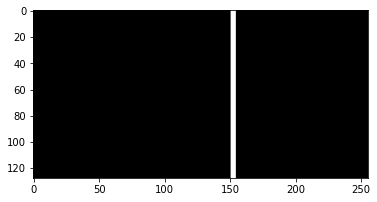

In [24]:
plt.figure()
plt.imshow(VideSystemDB_Y[1], cmap='gray')

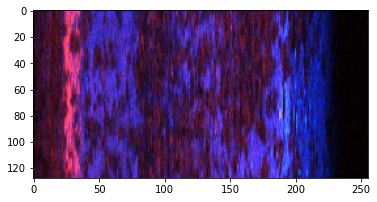

In [25]:
plt.figure()
plt.imshow(VideSystemDB_X[1])

In [26]:
vsTrainX, vsValX, vsTrainY, vsValY = train_test_split(VideSystemDB_X,VideSystemDB_Y,test_size=0.2, random_state=SEED)

In [27]:
# sevTrainX, sevValX, sevTrainY, sevValY = train_test_split(severstalDB_X,severstalDB_Y,test_size=0.2, random_state=SEED)
sevTrainX, sevValX, sevTrainY, sevValY = train_test_split(severstalDB_X[:3000],severstalDB_Y[:3000],test_size=0.2, random_state=SEED)

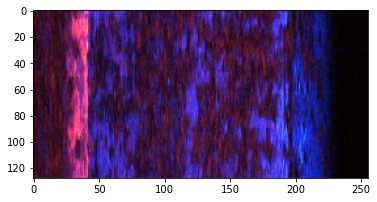

In [28]:
plt.figure()
plt.imshow(vsValX[1])

In [29]:
print(vsTrainY.shape)
print(vsTrainX.shape)

(512, 128, 256, 1)
(512, 128, 256, 3)


# MODEL DEFINITION AND TRAINING

In [30]:
from keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D, Normalization
from keras.layers.merge import concatenate

In [31]:
def encodingLR(inputLr,filters,k_size = 3, p = 'same', activation = 'relu'):
    conv = Convolution2D(filters=filters, kernel_size=k_size, padding=p, activation=activation)(inputLr)
    convDouble = Convolution2D(filters=filters, kernel_size=k_size, padding=p, activation=activation)(conv)
    pool = MaxPooling2D(pool_size=(2, 2))(convDouble)
    out = BatchNormalization()(pool)
    return(out,convDouble)

def decodingLR(inputLr,filters,k_size = 3, p = 'same', activation = 'relu'):
    up = UpSampling2D(size=(2,2))(inputLr)
    conv = Convolution2D(filters=filters, kernel_size=k_size, padding=p, activation=activation)(up)
    out = Convolution2D(filters=filters, kernel_size=k_size, padding=p, activation=activation)(conv)
    return(out)

In [32]:
def segmentation(inp_shape,merge_axis = -1):
    data = Input(shape=inp_shape)
    enc1,sl1 = encodingLR(data,32)
    enc1 = Dropout(0.7)(enc1)

    enc2,sl2 = encodingLR(enc1,64)
    enc2 = Dropout(0.7)(enc2)

    enc3,sl3 = encodingLR(enc2,64)
    enc3 = Dropout(0.6)(enc3)

    enc4,sl4 = encodingLR(enc3,128)
    
    enc4 = Dropout(0.5)(enc4)

    print(enc4.shape)
    print(sl4.shape)
    
    latent = Convolution2D(filters=256, kernel_size=3, padding='same', activation='relu')(enc4)

    dec4 = decodingLR(latent,256)
    skip4 = Concatenate()([sl4,dec4])
    # skip4 = concatenate([sl4,dec4],axis=merge_axis)
    convDec4 = Convolution2D(filters=256, kernel_size=3, padding='same', activation='relu')(skip4)
    
    dec3 = decodingLR(convDec4,256)
    skip3 = Concatenate()([sl3,dec3])
    # skip3 = concatenate([sl3,dec3],axis=merge_axis)
    convDec3 = Convolution2D(filters=256, kernel_size=3, padding='same', activation='relu')(skip3)

    dec2 = decodingLR(convDec3,128)
    skip2 = Concatenate()([sl2,dec2])
    # skip2 = concatenate([sl2,dec2],axis=merge_axis)
    convDec2 = Convolution2D(filters=128, kernel_size=3, padding='same', activation='relu')(skip2)
    
    dec1 = decodingLR(convDec2,64)
    skip1 = Concatenate()([sl1,dec1])
    # skip1 = concatenate([sl1,dec1],axis=merge_axis)
    convDec1 = Convolution2D(filters=64, kernel_size=3, padding='same', activation='relu')(skip1)

    
    outLat = Convolution2D(filters=1, kernel_size=3, padding='same', activation='sigmoid')(convDec1)

    
    model = Model(data, outLat)
    return(model)

In [33]:
def segModel2D(inp_shape,k_size = 3,merge_axis = -1):
    data = Input(shape=inp_shape)
    # norm = Normalization(axis=-1)(data)
    conv1 = Convolution2D(filters=32, kernel_size=k_size, padding='same', activation='relu')(data)
    conv1 = Convolution2D(filters=32, kernel_size=k_size, padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(pool1)
    conv2 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(pool2)
    conv3 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(pool3)
    conv4 = Convolution2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(pool4)

    up1 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(up1)
    conv6 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(conv6)
    merged1 = concatenate([conv4, conv6], axis=merge_axis)
    conv6 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(merged1)

    up2 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(up2)
    conv7 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(conv7)
    merged2 = concatenate([conv3, conv7], axis=merge_axis)
    conv7 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(merged2)

    up3 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Convolution2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(up3)
    conv8 = Convolution2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(conv8)
    merged3 = concatenate([conv2, conv8], axis=merge_axis)
    conv8 = Convolution2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(merged3)

    up4 = UpSampling2D(size=(2, 2))(conv8)
    conv9 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(up4)
    conv9 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(conv9)
    merged4 = concatenate([conv1, conv9], axis=merge_axis)
    conv9 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(merged4)

    conv10 = Convolution2D(filters=1, kernel_size=k_size, padding='same', activation='sigmoid')(conv9)

    output = conv10
    model = Model(data, output)
    return model

In [34]:
def iou_coef(y_true, y_pred, smooth=1):     #https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice(y_true, y_pred, smooth=1):    #https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - (dice_coef(y_true,y_pred))

    
def dice_new_loss(y_true, y_pred):
    return 1 - (dice(y_true,y_pred))

    
def iou_loss(y_true, y_pred):
    return 1 - (iou_coef(y_true,y_pred))

def tversky(y_true, y_pred, smooth=1, alpha=0.7):   #https://towardsdatascience.com/dealing-with-class-imbalanced-image-datasets-1cbd17de76b5
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

def focal_loss_fixed(y_true, y_pred, alpha= 0.25,gamma=2.0):        #https://github.com/mkocabas/focal-loss-keras/blob/master/focal_loss.py
	pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
	pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
	return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon())) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))

In [35]:
model = segmentation((IMAGE_SIZE[0],IMAGE_SIZE[1],3))

(None, 8, 16, 128)
(None, 16, 32, 128)


In [36]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy', dice, dice_coef, iou_coef],
)

## training on severstal

In [37]:
# CREATE CALLBACKS
checkpoint = tf.keras.callbacks.ModelCheckpoint(
						checkpointPath / Path('segmentationModel_Train_Severstal'), 
						monitor='val_dice', verbose=1, 
						save_best_only=True, mode='max')

callbacks_list = [checkpoint]

history = model.fit(
        x = sevTrainX,
        y = sevTrainY,
        epochs = 200,
        validation_data = [sevValX,sevValY],
        callbacks = callbacks_list,
        batch_size=16,
)

Epoch 1/200
150/150 [==============================] - ETA: 0s - loss: 0.1997 - accuracy: 0.9344 - dice: 0.1099 - dice_coef: 0.1593 - iou_coef: 0.0622
Epoch 1: val_dice improved from -inf to 0.03596, saving model to ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


150/150 [==============================] - 23s 107ms/step - loss: 0.1997 - accuracy: 0.9344 - dice: 0.1099 - dice_coef: 0.1593 - iou_coef: 0.0622 - val_loss: 0.2322 - val_accuracy: 0.9356 - val_dice: 0.0360 - val_dice_coef: 0.0493 - val_iou_coef: 0.0187
Epoch 2/200
150/150 [==============================] - ETA: 0s - loss: 0.1562 - accuracy: 0.9428 - dice: 0.1749 - dice_coef: 0.2589 - iou_coef: 0.1029
Epoch 2: val_dice did not improve from 0.03596
150/150 [==============================] - 13s 88ms/step - loss: 0.1562 - accuracy: 0.9428 - dice: 0.1749 - dice_coef: 0.2589 - iou_coef: 0.1029 - val_loss: 0.2816 - val_accuracy: 0.9356 - val_dice: 0.0214 - val_dice_coef: 0.0244 - val_iou_coef: 0.0115
Epoch 3/200
150/150 [==============================] - ETA: 0s - loss: 0.1395 - accuracy: 0.9465 - dice: 0.2253 - dice_coef: 0.3225 - iou_coef: 0.1364
Epoch 3: val_dice improved from 0.03596 to 0.05163, saving model to ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Sever

INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


150/150 [==============================] - 15s 99ms/step - loss: 0.1395 - accuracy: 0.9465 - dice: 0.2253 - dice_coef: 0.3225 - iou_coef: 0.1364 - val_loss: 0.2549 - val_accuracy: 0.9358 - val_dice: 0.0516 - val_dice_coef: 0.0599 - val_iou_coef: 0.0281
Epoch 4/200
150/150 [==============================] - ETA: 0s - loss: 0.1365 - accuracy: 0.9475 - dice: 0.2367 - dice_coef: 0.3352 - iou_coef: 0.1445
Epoch 4: val_dice improved from 0.05163 to 0.16027, saving model to ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


150/150 [==============================] - 15s 99ms/step - loss: 0.1365 - accuracy: 0.9475 - dice: 0.2367 - dice_coef: 0.3352 - iou_coef: 0.1445 - val_loss: 0.1686 - val_accuracy: 0.9400 - val_dice: 0.1603 - val_dice_coef: 0.2102 - val_iou_coef: 0.0935
Epoch 5/200
150/150 [==============================] - ETA: 0s - loss: 0.1324 - accuracy: 0.9487 - dice: 0.2535 - dice_coef: 0.3554 - iou_coef: 0.1563
Epoch 5: val_dice did not improve from 0.16027
150/150 [==============================] - 13s 87ms/step - loss: 0.1324 - accuracy: 0.9487 - dice: 0.2535 - dice_coef: 0.3554 - iou_coef: 0.1563 - val_loss: 0.1989 - val_accuracy: 0.9380 - val_dice: 0.0874 - val_dice_coef: 0.1401 - val_iou_coef: 0.0496
Epoch 6/200
150/150 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9496 - dice: 0.2633 - dice_coef: 0.3685 - iou_coef: 0.1634
Epoch 6: val_dice improved from 0.16027 to 0.20196, saving model to ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severs

INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


150/150 [==============================] - 15s 100ms/step - loss: 0.1282 - accuracy: 0.9496 - dice: 0.2633 - dice_coef: 0.3685 - iou_coef: 0.1634 - val_loss: 0.1763 - val_accuracy: 0.9425 - val_dice: 0.2020 - val_dice_coef: 0.2578 - val_iou_coef: 0.1229
Epoch 7/200
150/150 [==============================] - ETA: 0s - loss: 0.1247 - accuracy: 0.9509 - dice: 0.2734 - dice_coef: 0.3837 - iou_coef: 0.1709
Epoch 7: val_dice improved from 0.20196 to 0.26515, saving model to ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


150/150 [==============================] - 15s 98ms/step - loss: 0.1247 - accuracy: 0.9509 - dice: 0.2734 - dice_coef: 0.3837 - iou_coef: 0.1709 - val_loss: 0.1399 - val_accuracy: 0.9454 - val_dice: 0.2652 - val_dice_coef: 0.3304 - val_iou_coef: 0.1637
Epoch 8/200
150/150 [==============================] - ETA: 0s - loss: 0.1243 - accuracy: 0.9512 - dice: 0.2778 - dice_coef: 0.3866 - iou_coef: 0.1743
Epoch 8: val_dice improved from 0.26515 to 0.30401, saving model to ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


150/150 [==============================] - 15s 98ms/step - loss: 0.1243 - accuracy: 0.9512 - dice: 0.2778 - dice_coef: 0.3866 - iou_coef: 0.1743 - val_loss: 0.1637 - val_accuracy: 0.9464 - val_dice: 0.3040 - val_dice_coef: 0.3584 - val_iou_coef: 0.1944
Epoch 9/200
150/150 [==============================] - ETA: 0s - loss: 0.1221 - accuracy: 0.9513 - dice: 0.2818 - dice_coef: 0.3925 - iou_coef: 0.1772
Epoch 9: val_dice did not improve from 0.30401
150/150 [==============================] - 13s 86ms/step - loss: 0.1221 - accuracy: 0.9513 - dice: 0.2818 - dice_coef: 0.3925 - iou_coef: 0.1772 - val_loss: 0.1922 - val_accuracy: 0.9435 - val_dice: 0.1755 - val_dice_coef: 0.2632 - val_iou_coef: 0.1079
Epoch 10/200
150/150 [==============================] - ETA: 0s - loss: 0.1215 - accuracy: 0.9513 - dice: 0.2844 - dice_coef: 0.3938 - iou_coef: 0.1788
Epoch 10: val_dice did not improve from 0.30401
150/150 [==============================] - 13s 89ms/step - loss: 0.1215 - accuracy: 0.9513 - dic

INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


150/150 [==============================] - 15s 101ms/step - loss: 0.1163 - accuracy: 0.9529 - dice: 0.3039 - dice_coef: 0.4188 - iou_coef: 0.1936 - val_loss: 0.1409 - val_accuracy: 0.9484 - val_dice: 0.3123 - val_dice_coef: 0.3799 - val_iou_coef: 0.1986
Epoch 16/200
150/150 [==============================] - ETA: 0s - loss: 0.1139 - accuracy: 0.9536 - dice: 0.3096 - dice_coef: 0.4257 - iou_coef: 0.1978
Epoch 16: val_dice did not improve from 0.31226
150/150 [==============================] - 13s 88ms/step - loss: 0.1139 - accuracy: 0.9536 - dice: 0.3096 - dice_coef: 0.4257 - iou_coef: 0.1978 - val_loss: 0.1252 - val_accuracy: 0.9494 - val_dice: 0.2910 - val_dice_coef: 0.3764 - val_iou_coef: 0.1825
Epoch 17/200
150/150 [==============================] - ETA: 0s - loss: 0.1140 - accuracy: 0.9536 - dice: 0.3093 - dice_coef: 0.4259 - iou_coef: 0.1979
Epoch 17: val_dice did not improve from 0.31226
150/150 [==============================] - 14s 92ms/step - loss: 0.1140 - accuracy: 0.9536 - 

INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


150/150 [==============================] - 15s 101ms/step - loss: 0.1139 - accuracy: 0.9539 - dice: 0.3138 - dice_coef: 0.4254 - iou_coef: 0.2009 - val_loss: 0.1301 - val_accuracy: 0.9502 - val_dice: 0.3287 - val_dice_coef: 0.4144 - val_iou_coef: 0.2133
Epoch 23/200
150/150 [==============================] - ETA: 0s - loss: 0.1107 - accuracy: 0.9546 - dice: 0.3224 - dice_coef: 0.4434 - iou_coef: 0.2080
Epoch 23: val_dice did not improve from 0.32867
150/150 [==============================] - 13s 89ms/step - loss: 0.1107 - accuracy: 0.9546 - dice: 0.3224 - dice_coef: 0.4434 - iou_coef: 0.2080 - val_loss: 0.1648 - val_accuracy: 0.9468 - val_dice: 0.2737 - val_dice_coef: 0.3438 - val_iou_coef: 0.1749
Epoch 24/200
150/150 [==============================] - ETA: 0s - loss: 0.1117 - accuracy: 0.9544 - dice: 0.3202 - dice_coef: 0.4359 - iou_coef: 0.2063
Epoch 24: val_dice did not improve from 0.32867
150/150 [==============================] - 13s 90ms/step - loss: 0.1117 - accuracy: 0.9544 - 

INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


150/150 [==============================] - 15s 99ms/step - loss: 0.1104 - accuracy: 0.9549 - dice: 0.3285 - dice_coef: 0.4446 - iou_coef: 0.2126 - val_loss: 0.1233 - val_accuracy: 0.9516 - val_dice: 0.3420 - val_dice_coef: 0.4281 - val_iou_coef: 0.2232
Epoch 28/200
150/150 [==============================] - ETA: 0s - loss: 0.1086 - accuracy: 0.9554 - dice: 0.3318 - dice_coef: 0.4525 - iou_coef: 0.2155
Epoch 28: val_dice did not improve from 0.34198
150/150 [==============================] - 13s 87ms/step - loss: 0.1086 - accuracy: 0.9554 - dice: 0.3318 - dice_coef: 0.4525 - iou_coef: 0.2155 - val_loss: 0.1218 - val_accuracy: 0.9518 - val_dice: 0.3273 - val_dice_coef: 0.4232 - val_iou_coef: 0.2109
Epoch 29/200
150/150 [==============================] - ETA: 0s - loss: 0.1099 - accuracy: 0.9552 - dice: 0.3285 - dice_coef: 0.4507 - iou_coef: 0.2132
Epoch 29: val_dice did not improve from 0.34198
150/150 [==============================] - 13s 87ms/step - loss: 0.1099 - accuracy: 0.9552 - d

INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


150/150 [==============================] - 15s 100ms/step - loss: 0.1084 - accuracy: 0.9555 - dice: 0.3350 - dice_coef: 0.4497 - iou_coef: 0.2178 - val_loss: 0.1103 - val_accuracy: 0.9541 - val_dice: 0.3577 - val_dice_coef: 0.4571 - val_iou_coef: 0.2348
Epoch 36/200
150/150 [==============================] - ETA: 0s - loss: 0.1070 - accuracy: 0.9558 - dice: 0.3372 - dice_coef: 0.4555 - iou_coef: 0.2196
Epoch 36: val_dice did not improve from 0.35766
150/150 [==============================] - 13s 87ms/step - loss: 0.1070 - accuracy: 0.9558 - dice: 0.3372 - dice_coef: 0.4555 - iou_coef: 0.2196 - val_loss: 0.1205 - val_accuracy: 0.9517 - val_dice: 0.3331 - val_dice_coef: 0.4264 - val_iou_coef: 0.2159
Epoch 37/200
150/150 [==============================] - ETA: 0s - loss: 0.1077 - accuracy: 0.9555 - dice: 0.3400 - dice_coef: 0.4578 - iou_coef: 0.2215
Epoch 37: val_dice did not improve from 0.35766
150/150 [==============================] - 13s 87ms/step - loss: 0.1077 - accuracy: 0.9555 - 

INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


150/150 [==============================] - 15s 97ms/step - loss: 0.1030 - accuracy: 0.9572 - dice: 0.3543 - dice_coef: 0.4775 - iou_coef: 0.2334 - val_loss: 0.1321 - val_accuracy: 0.9517 - val_dice: 0.3839 - val_dice_coef: 0.4738 - val_iou_coef: 0.2589
Epoch 50/200
150/150 [==============================] - ETA: 0s - loss: 0.1043 - accuracy: 0.9567 - dice: 0.3541 - dice_coef: 0.4714 - iou_coef: 0.2333
Epoch 50: val_dice did not improve from 0.38395
150/150 [==============================] - 13s 87ms/step - loss: 0.1043 - accuracy: 0.9567 - dice: 0.3541 - dice_coef: 0.4714 - iou_coef: 0.2333 - val_loss: 0.1172 - val_accuracy: 0.9509 - val_dice: 0.3365 - val_dice_coef: 0.4251 - val_iou_coef: 0.2177
Epoch 51/200
150/150 [==============================] - ETA: 0s - loss: 0.1024 - accuracy: 0.9570 - dice: 0.3595 - dice_coef: 0.4833 - iou_coef: 0.2370
Epoch 51: val_dice did not improve from 0.38395
150/150 [==============================] - 13s 87ms/step - loss: 0.1024 - accuracy: 0.9570 - d

INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


150/150 [==============================] - 15s 98ms/step - loss: 0.0979 - accuracy: 0.9587 - dice: 0.3779 - dice_coef: 0.5050 - iou_coef: 0.2519 - val_loss: 0.1213 - val_accuracy: 0.9525 - val_dice: 0.3849 - val_dice_coef: 0.4769 - val_iou_coef: 0.2576
Epoch 70/200
150/150 [==============================] - ETA: 0s - loss: 0.0977 - accuracy: 0.9586 - dice: 0.3806 - dice_coef: 0.4984 - iou_coef: 0.2547
Epoch 70: val_dice did not improve from 0.38495
150/150 [==============================] - 13s 86ms/step - loss: 0.0977 - accuracy: 0.9586 - dice: 0.3806 - dice_coef: 0.4984 - iou_coef: 0.2547 - val_loss: 0.1243 - val_accuracy: 0.9520 - val_dice: 0.3595 - val_dice_coef: 0.4599 - val_iou_coef: 0.2387
Epoch 71/200
150/150 [==============================] - ETA: 0s - loss: 0.0974 - accuracy: 0.9587 - dice: 0.3811 - dice_coef: 0.5030 - iou_coef: 0.2547
Epoch 71: val_dice did not improve from 0.38495
150/150 [==============================] - 13s 86ms/step - loss: 0.0974 - accuracy: 0.9587 - d

INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


150/150 [==============================] - 15s 101ms/step - loss: 0.0971 - accuracy: 0.9589 - dice: 0.3844 - dice_coef: 0.5007 - iou_coef: 0.2573 - val_loss: 0.1135 - val_accuracy: 0.9532 - val_dice: 0.3854 - val_dice_coef: 0.4778 - val_iou_coef: 0.2576
Epoch 75/200
150/150 [==============================] - ETA: 0s - loss: 0.0977 - accuracy: 0.9585 - dice: 0.3815 - dice_coef: 0.5009 - iou_coef: 0.2544
Epoch 75: val_dice did not improve from 0.38540
150/150 [==============================] - 13s 87ms/step - loss: 0.0977 - accuracy: 0.9585 - dice: 0.3815 - dice_coef: 0.5009 - iou_coef: 0.2544 - val_loss: 0.1236 - val_accuracy: 0.9518 - val_dice: 0.3540 - val_dice_coef: 0.4509 - val_iou_coef: 0.2339
Epoch 76/200
150/150 [==============================] - ETA: 0s - loss: 0.0961 - accuracy: 0.9592 - dice: 0.3853 - dice_coef: 0.5128 - iou_coef: 0.2581
Epoch 76: val_dice did not improve from 0.38540
150/150 [==============================] - 13s 86ms/step - loss: 0.0961 - accuracy: 0.9592 - 

INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_Train_Severstal\assets


150/150 [==============================] - 15s 98ms/step - loss: 0.0939 - accuracy: 0.9601 - dice: 0.3957 - dice_coef: 0.5205 - iou_coef: 0.2668 - val_loss: 0.1256 - val_accuracy: 0.9537 - val_dice: 0.3946 - val_dice_coef: 0.4878 - val_iou_coef: 0.2667
Epoch 87/200
150/150 [==============================] - ETA: 0s - loss: 0.0934 - accuracy: 0.9604 - dice: 0.3965 - dice_coef: 0.5253 - iou_coef: 0.2679
Epoch 87: val_dice did not improve from 0.39456
150/150 [==============================] - 13s 86ms/step - loss: 0.0934 - accuracy: 0.9604 - dice: 0.3965 - dice_coef: 0.5253 - iou_coef: 0.2679 - val_loss: 0.1466 - val_accuracy: 0.9424 - val_dice: 0.3001 - val_dice_coef: 0.3991 - val_iou_coef: 0.1950
Epoch 88/200
150/150 [==============================] - ETA: 0s - loss: 0.0929 - accuracy: 0.9603 - dice: 0.3982 - dice_coef: 0.5264 - iou_coef: 0.2690
Epoch 88: val_dice did not improve from 0.39456
150/150 [==============================] - 13s 86ms/step - loss: 0.0929 - accuracy: 0.9603 - d

In [38]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train segmentation loss'))
fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Valid segmentation loss'))
fig.add_trace(go.Scatter(
                    y=history.history['accuracy'],
                    name='Train segmentation accuracy'))
fig.add_trace(go.Scatter(
                    y=history.history['val_accuracy'],
                    name='Valid segmentation accuracy'))
                    
fig.add_trace(go.Scatter(
                    y=history.history['dice'],
                    name='Train segmentation dice'))
fig.add_trace(go.Scatter(
                    y=history.history['val_dice'],
                    name='Valid segmentation dice'))
fig.add_trace(go.Scatter(
                    y=history.history['dice_coef'],
                    name='Train segmentation dicce coef'))
fig.add_trace(go.Scatter(
                    y=history.history['val_dice_coef'],
                    name='Valid segmentation dice coef'))
                    
fig.add_trace(go.Scatter(
                    y=history.history['iou_coef'],
                    name='Train segmentation iou'))
fig.add_trace(go.Scatter(
                    y=history.history['val_iou_coef'],
                    name='Valid segmentation iou'))
# fig.add_trace(go.Scatter(
#                     y=history.history['tversky'],
#                     name='Train segmentation tversky'))
# fig.add_trace(go.Scatter(
#                     y=history.history['val_tversky'],
#                     name='Valid segmentation tversky'))

fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy / Loss',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy / Loss')
fig.show()

<Figure size 432x288 with 0 Axes>

In [39]:
p = model.predict(sevValX)

19/19 [==============================] - 3s 95ms/step


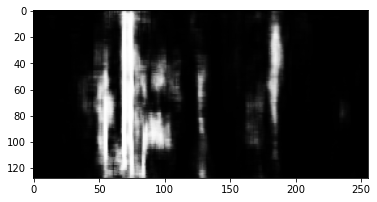

In [40]:
plt.figure()
plt.imshow(p[100],cmap='gray')

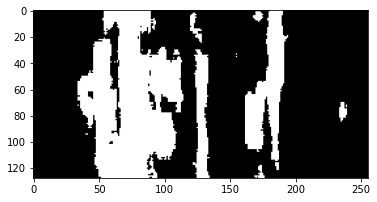

In [41]:
plt.figure()
plt.imshow(p[100]>0.5,cmap='gray')

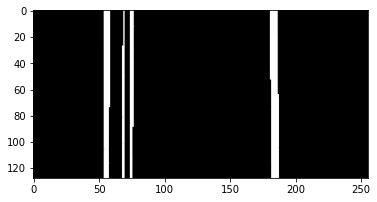

In [42]:
plt.figure()
plt.imshow(sevValY[100], cmap='gray')

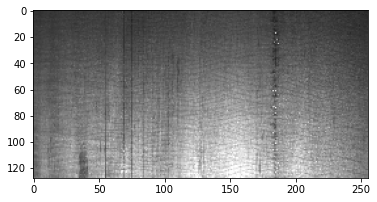

In [43]:
plt.figure()

plt.imshow(sevValX[100])

## Fine tuning on Video Systems

In [44]:
#LOAD FREZE, TRAIN, TRY
bestPt = checkpointPath / Path('segmentationModel_Train_Severstal')
model = tf.keras.models.load_model(bestPt, custom_objects={'dice':dice, 'dice_coef':dice_coef,'iou_coef':iou_coef,'tversky':tversky, 'focal_tversky_loss': focal_tversky_loss})
for layer in model.layers[:-1]:
        layer.trainable = False

In [45]:
# CREATE CALLBACKS
checkpoint = tf.keras.callbacks.ModelCheckpoint(
						checkpointPath / Path('segmentationModel_SEV_PRE_VS_FREEZE'), 
						monitor='val_dice', verbose=1, 
						save_best_only=True, mode='max')

callbacks_list = [checkpoint]

history = model.fit(
        x = vsTrainX,
        y = vsTrainY,
        epochs = 200,
        validation_data = [vsValX,vsValY],
        callbacks = callbacks_list,
        batch_size=16,
)

Epoch 1/200
32/32 [==============================] - ETA: 0s - loss: 0.0329 - accuracy: 0.9845 - dice: 0.0111 - dice_coef: 0.0051 - iou_coef: 0.0091
Epoch 1: val_dice improved from -inf to 0.00964, saving model to ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 6s 155ms/step - loss: 0.0329 - accuracy: 0.9845 - dice: 0.0111 - dice_coef: 0.0051 - iou_coef: 0.0091 - val_loss: 0.0265 - val_accuracy: 0.9850 - val_dice: 0.0096 - val_dice_coef: 0.0061 - val_iou_coef: 0.0073
Epoch 2/200
32/32 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.9867 - dice: 0.0103 - dice_coef: 0.0069 - iou_coef: 0.0077
Epoch 2: val_dice improved from 0.00964 to 0.01165, saving model to ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 147ms/step - loss: 0.0237 - accuracy: 0.9867 - dice: 0.0103 - dice_coef: 0.0069 - iou_coef: 0.0077 - val_loss: 0.0259 - val_accuracy: 0.9850 - val_dice: 0.0116 - val_dice_coef: 0.0084 - val_iou_coef: 0.0083
Epoch 3/200
32/32 [==============================] - ETA: 0s - loss: 0.0230 - accuracy: 0.9867 - dice: 0.0127 - dice_coef: 0.0096 - iou_coef: 0.0090
Epoch 3: val_dice improved from 0.01165 to 0.01427, saving model to ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 149ms/step - loss: 0.0230 - accuracy: 0.9867 - dice: 0.0127 - dice_coef: 0.0096 - iou_coef: 0.0090 - val_loss: 0.0253 - val_accuracy: 0.9850 - val_dice: 0.0143 - val_dice_coef: 0.0120 - val_iou_coef: 0.0095
Epoch 4/200
32/32 [==============================] - ETA: 0s - loss: 0.0228 - accuracy: 0.9867 - dice: 0.0144 - dice_coef: 0.0119 - iou_coef: 0.0099
Epoch 4: val_dice improved from 0.01427 to 0.01697, saving model to ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 149ms/step - loss: 0.0228 - accuracy: 0.9867 - dice: 0.0144 - dice_coef: 0.0119 - iou_coef: 0.0099 - val_loss: 0.0253 - val_accuracy: 0.9850 - val_dice: 0.0170 - val_dice_coef: 0.0139 - val_iou_coef: 0.0116
Epoch 5/200
32/32 [==============================] - ETA: 0s - loss: 0.0225 - accuracy: 0.9867 - dice: 0.0156 - dice_coef: 0.0135 - iou_coef: 0.0105
Epoch 5: val_dice improved from 0.01697 to 0.02069, saving model to ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 148ms/step - loss: 0.0225 - accuracy: 0.9867 - dice: 0.0156 - dice_coef: 0.0135 - iou_coef: 0.0105 - val_loss: 0.0256 - val_accuracy: 0.9850 - val_dice: 0.0207 - val_dice_coef: 0.0187 - val_iou_coef: 0.0135
Epoch 6/200
32/32 [==============================] - ETA: 0s - loss: 0.0221 - accuracy: 0.9867 - dice: 0.0181 - dice_coef: 0.0167 - iou_coef: 0.0120
Epoch 6: val_dice improved from 0.02069 to 0.02557, saving model to ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 155ms/step - loss: 0.0221 - accuracy: 0.9867 - dice: 0.0181 - dice_coef: 0.0167 - iou_coef: 0.0120 - val_loss: 0.0246 - val_accuracy: 0.9850 - val_dice: 0.0256 - val_dice_coef: 0.0263 - val_iou_coef: 0.0157
Epoch 7/200
32/32 [==============================] - ETA: 0s - loss: 0.0219 - accuracy: 0.9867 - dice: 0.0200 - dice_coef: 0.0198 - iou_coef: 0.0128
Epoch 7: val_dice did not improve from 0.02557
32/32 [==============================] - 3s 88ms/step - loss: 0.0219 - accuracy: 0.9867 - dice: 0.0200 - dice_coef: 0.0198 - iou_coef: 0.0128 - val_loss: 0.0250 - val_accuracy: 0.9850 - val_dice: 0.0234 - val_dice_coef: 0.0227 - val_iou_coef: 0.0153
Epoch 8/200
32/32 [==============================] - ETA: 0s - loss: 0.0218 - accuracy: 0.9867 - dice: 0.0210 - dice_coef: 0.0214 - iou_coef: 0.0135
Epoch 8: val_dice did not improve from 0.02557
32/32 [==============================] - 3s 86ms/step - loss: 0.0218 - accuracy: 0.9867 - dice: 0.0210 - di

INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 150ms/step - loss: 0.0214 - accuracy: 0.9867 - dice: 0.0238 - dice_coef: 0.0258 - iou_coef: 0.0151 - val_loss: 0.0249 - val_accuracy: 0.9850 - val_dice: 0.0259 - val_dice_coef: 0.0266 - val_iou_coef: 0.0168
Epoch 11/200
32/32 [==============================] - ETA: 0s - loss: 0.0213 - accuracy: 0.9867 - dice: 0.0245 - dice_coef: 0.0268 - iou_coef: 0.0155
Epoch 11: val_dice improved from 0.02588 to 0.03108, saving model to ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 149ms/step - loss: 0.0213 - accuracy: 0.9867 - dice: 0.0245 - dice_coef: 0.0268 - iou_coef: 0.0155 - val_loss: 0.0237 - val_accuracy: 0.9850 - val_dice: 0.0311 - val_dice_coef: 0.0377 - val_iou_coef: 0.0186
Epoch 12/200
32/32 [==============================] - ETA: 0s - loss: 0.0210 - accuracy: 0.9867 - dice: 0.0271 - dice_coef: 0.0319 - iou_coef: 0.0167
Epoch 12: val_dice did not improve from 0.03108
32/32 [==============================] - 3s 86ms/step - loss: 0.0210 - accuracy: 0.9867 - dice: 0.0271 - dice_coef: 0.0319 - iou_coef: 0.0167 - val_loss: 0.0239 - val_accuracy: 0.9850 - val_dice: 0.0292 - val_dice_coef: 0.0348 - val_iou_coef: 0.0175
Epoch 13/200
32/32 [==============================] - ETA: 0s - loss: 0.0208 - accuracy: 0.9867 - dice: 0.0284 - dice_coef: 0.0333 - iou_coef: 0.0176
Epoch 13: val_dice did not improve from 0.03108
32/32 [==============================] - 3s 87ms/step - loss: 0.0208 - accuracy: 0.9867 - dice: 0.0284 

INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 153ms/step - loss: 0.0204 - accuracy: 0.9867 - dice: 0.0344 - dice_coef: 0.0431 - iou_coef: 0.0210 - val_loss: 0.0227 - val_accuracy: 0.9850 - val_dice: 0.0397 - val_dice_coef: 0.0504 - val_iou_coef: 0.0234
Epoch 15/200
32/32 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.9867 - dice: 0.0365 - dice_coef: 0.0470 - iou_coef: 0.0220
Epoch 15: val_dice improved from 0.03970 to 0.04356, saving model to ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 149ms/step - loss: 0.0200 - accuracy: 0.9867 - dice: 0.0365 - dice_coef: 0.0470 - iou_coef: 0.0220 - val_loss: 0.0229 - val_accuracy: 0.9850 - val_dice: 0.0436 - val_dice_coef: 0.0591 - val_iou_coef: 0.0256
Epoch 16/200
32/32 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.9867 - dice: 0.0367 - dice_coef: 0.0453 - iou_coef: 0.0221
Epoch 16: val_dice did not improve from 0.04356
32/32 [==============================] - 3s 86ms/step - loss: 0.0200 - accuracy: 0.9867 - dice: 0.0367 - dice_coef: 0.0453 - iou_coef: 0.0221 - val_loss: 0.0232 - val_accuracy: 0.9850 - val_dice: 0.0394 - val_dice_coef: 0.0511 - val_iou_coef: 0.0227
Epoch 17/200
32/32 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9867 - dice: 0.0385 - dice_coef: 0.0484 - iou_coef: 0.0231
Epoch 17: val_dice improved from 0.04356 to 0.04389, saving model to ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE

INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 147ms/step - loss: 0.0198 - accuracy: 0.9867 - dice: 0.0385 - dice_coef: 0.0484 - iou_coef: 0.0231 - val_loss: 0.0225 - val_accuracy: 0.9850 - val_dice: 0.0439 - val_dice_coef: 0.0579 - val_iou_coef: 0.0260
Epoch 18/200
32/32 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9867 - dice: 0.0396 - dice_coef: 0.0514 - iou_coef: 0.0237
Epoch 18: val_dice improved from 0.04389 to 0.04695, saving model to ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 148ms/step - loss: 0.0198 - accuracy: 0.9867 - dice: 0.0396 - dice_coef: 0.0514 - iou_coef: 0.0237 - val_loss: 0.0231 - val_accuracy: 0.9850 - val_dice: 0.0469 - val_dice_coef: 0.0638 - val_iou_coef: 0.0277
Epoch 19/200
32/32 [==============================] - ETA: 0s - loss: 0.0195 - accuracy: 0.9867 - dice: 0.0409 - dice_coef: 0.0528 - iou_coef: 0.0245
Epoch 19: val_dice improved from 0.04695 to 0.04707, saving model to ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 151ms/step - loss: 0.0195 - accuracy: 0.9867 - dice: 0.0409 - dice_coef: 0.0528 - iou_coef: 0.0245 - val_loss: 0.0225 - val_accuracy: 0.9850 - val_dice: 0.0471 - val_dice_coef: 0.0648 - val_iou_coef: 0.0280
Epoch 20/200
32/32 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 0.9867 - dice: 0.0425 - dice_coef: 0.0544 - iou_coef: 0.0253
Epoch 20: val_dice improved from 0.04707 to 0.04832, saving model to ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 156ms/step - loss: 0.0194 - accuracy: 0.9867 - dice: 0.0425 - dice_coef: 0.0544 - iou_coef: 0.0253 - val_loss: 0.0227 - val_accuracy: 0.9850 - val_dice: 0.0483 - val_dice_coef: 0.0648 - val_iou_coef: 0.0285
Epoch 21/200
32/32 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 0.9867 - dice: 0.0441 - dice_coef: 0.0575 - iou_coef: 0.0263
Epoch 21: val_dice improved from 0.04832 to 0.04931, saving model to ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 153ms/step - loss: 0.0194 - accuracy: 0.9867 - dice: 0.0441 - dice_coef: 0.0575 - iou_coef: 0.0263 - val_loss: 0.0222 - val_accuracy: 0.9850 - val_dice: 0.0493 - val_dice_coef: 0.0678 - val_iou_coef: 0.0296
Epoch 22/200
32/32 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 0.9867 - dice: 0.0456 - dice_coef: 0.0600 - iou_coef: 0.0270
Epoch 22: val_dice improved from 0.04931 to 0.04967, saving model to ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 153ms/step - loss: 0.0192 - accuracy: 0.9867 - dice: 0.0456 - dice_coef: 0.0600 - iou_coef: 0.0270 - val_loss: 0.0225 - val_accuracy: 0.9850 - val_dice: 0.0497 - val_dice_coef: 0.0650 - val_iou_coef: 0.0293
Epoch 23/200
32/32 [==============================] - ETA: 0s - loss: 0.0191 - accuracy: 0.9867 - dice: 0.0460 - dice_coef: 0.0601 - iou_coef: 0.0273
Epoch 23: val_dice improved from 0.04967 to 0.05072, saving model to ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 155ms/step - loss: 0.0191 - accuracy: 0.9867 - dice: 0.0460 - dice_coef: 0.0601 - iou_coef: 0.0273 - val_loss: 0.0219 - val_accuracy: 0.9850 - val_dice: 0.0507 - val_dice_coef: 0.0694 - val_iou_coef: 0.0298
Epoch 24/200
32/32 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9867 - dice: 0.0486 - dice_coef: 0.0636 - iou_coef: 0.0288
Epoch 24: val_dice improved from 0.05072 to 0.05133, saving model to ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 156ms/step - loss: 0.0189 - accuracy: 0.9867 - dice: 0.0486 - dice_coef: 0.0636 - iou_coef: 0.0288 - val_loss: 0.0222 - val_accuracy: 0.9850 - val_dice: 0.0513 - val_dice_coef: 0.0667 - val_iou_coef: 0.0303
Epoch 25/200
32/32 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9867 - dice: 0.0471 - dice_coef: 0.0622 - iou_coef: 0.0279
Epoch 25: val_dice improved from 0.05133 to 0.05177, saving model to ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 152ms/step - loss: 0.0189 - accuracy: 0.9867 - dice: 0.0471 - dice_coef: 0.0622 - iou_coef: 0.0279 - val_loss: 0.0220 - val_accuracy: 0.9850 - val_dice: 0.0518 - val_dice_coef: 0.0675 - val_iou_coef: 0.0303
Epoch 26/200
32/32 [==============================] - ETA: 0s - loss: 0.0188 - accuracy: 0.9867 - dice: 0.0492 - dice_coef: 0.0654 - iou_coef: 0.0292
Epoch 26: val_dice did not improve from 0.05177
32/32 [==============================] - 3s 91ms/step - loss: 0.0188 - accuracy: 0.9867 - dice: 0.0492 - dice_coef: 0.0654 - iou_coef: 0.0292 - val_loss: 0.0218 - val_accuracy: 0.9850 - val_dice: 0.0515 - val_dice_coef: 0.0681 - val_iou_coef: 0.0304
Epoch 27/200
32/32 [==============================] - ETA: 0s - loss: 0.0187 - accuracy: 0.9867 - dice: 0.0497 - dice_coef: 0.0651 - iou_coef: 0.0295
Epoch 27: val_dice did not improve from 0.05177
32/32 [==============================] - 3s 88ms/step - loss: 0.0187 - accuracy: 0.9867 - dice: 0.0497 

INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 152ms/step - loss: 0.0186 - accuracy: 0.9867 - dice: 0.0503 - dice_coef: 0.0668 - iou_coef: 0.0297 - val_loss: 0.0223 - val_accuracy: 0.9850 - val_dice: 0.0529 - val_dice_coef: 0.0693 - val_iou_coef: 0.0313
Epoch 29/200
32/32 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9867 - dice: 0.0518 - dice_coef: 0.0690 - iou_coef: 0.0306
Epoch 29: val_dice improved from 0.05295 to 0.05424, saving model to ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 154ms/step - loss: 0.0185 - accuracy: 0.9867 - dice: 0.0518 - dice_coef: 0.0690 - iou_coef: 0.0306 - val_loss: 0.0221 - val_accuracy: 0.9850 - val_dice: 0.0542 - val_dice_coef: 0.0720 - val_iou_coef: 0.0320
Epoch 30/200
32/32 [==============================] - ETA: 0s - loss: 0.0184 - accuracy: 0.9867 - dice: 0.0508 - dice_coef: 0.0676 - iou_coef: 0.0301
Epoch 30: val_dice did not improve from 0.05424
32/32 [==============================] - 3s 89ms/step - loss: 0.0184 - accuracy: 0.9867 - dice: 0.0508 - dice_coef: 0.0676 - iou_coef: 0.0301 - val_loss: 0.0218 - val_accuracy: 0.9850 - val_dice: 0.0537 - val_dice_coef: 0.0703 - val_iou_coef: 0.0316
Epoch 31/200
32/32 [==============================] - ETA: 0s - loss: 0.0184 - accuracy: 0.9867 - dice: 0.0546 - dice_coef: 0.0717 - iou_coef: 0.0322
Epoch 31: val_dice did not improve from 0.05424
32/32 [==============================] - 3s 88ms/step - loss: 0.0184 - accuracy: 0.9867 - dice: 0.0546 

INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 147ms/step - loss: 0.0182 - accuracy: 0.9867 - dice: 0.0532 - dice_coef: 0.0714 - iou_coef: 0.0314 - val_loss: 0.0220 - val_accuracy: 0.9850 - val_dice: 0.0558 - val_dice_coef: 0.0764 - val_iou_coef: 0.0330
Epoch 33/200
32/32 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9867 - dice: 0.0533 - dice_coef: 0.0704 - iou_coef: 0.0316
Epoch 33: val_dice did not improve from 0.05575
32/32 [==============================] - 3s 88ms/step - loss: 0.0183 - accuracy: 0.9867 - dice: 0.0533 - dice_coef: 0.0704 - iou_coef: 0.0316 - val_loss: 0.0225 - val_accuracy: 0.9850 - val_dice: 0.0503 - val_dice_coef: 0.0674 - val_iou_coef: 0.0294
Epoch 34/200
32/32 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.9867 - dice: 0.0534 - dice_coef: 0.0707 - iou_coef: 0.0314
Epoch 34: val_dice did not improve from 0.05575
32/32 [==============================] - 3s 88ms/step - loss: 0.0181 - accuracy: 0.9867 - dice: 0.0534 

INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 154ms/step - loss: 0.0179 - accuracy: 0.9867 - dice: 0.0560 - dice_coef: 0.0735 - iou_coef: 0.0330 - val_loss: 0.0219 - val_accuracy: 0.9850 - val_dice: 0.0580 - val_dice_coef: 0.0752 - val_iou_coef: 0.0339
Epoch 39/200
32/32 [==============================] - ETA: 0s - loss: 0.0179 - accuracy: 0.9867 - dice: 0.0569 - dice_coef: 0.0769 - iou_coef: 0.0335
Epoch 39: val_dice did not improve from 0.05799
32/32 [==============================] - 3s 89ms/step - loss: 0.0179 - accuracy: 0.9867 - dice: 0.0569 - dice_coef: 0.0769 - iou_coef: 0.0335 - val_loss: 0.0219 - val_accuracy: 0.9850 - val_dice: 0.0554 - val_dice_coef: 0.0715 - val_iou_coef: 0.0325
Epoch 40/200
32/32 [==============================] - ETA: 0s - loss: 0.0177 - accuracy: 0.9867 - dice: 0.0587 - dice_coef: 0.0773 - iou_coef: 0.0345
Epoch 40: val_dice did not improve from 0.05799
32/32 [==============================] - 3s 88ms/step - loss: 0.0177 - accuracy: 0.9867 - dice: 0.0587 

INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 149ms/step - loss: 0.0175 - accuracy: 0.9867 - dice: 0.0602 - dice_coef: 0.0818 - iou_coef: 0.0353 - val_loss: 0.0222 - val_accuracy: 0.9850 - val_dice: 0.0597 - val_dice_coef: 0.0757 - val_iou_coef: 0.0353
Epoch 43/200
32/32 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.9867 - dice: 0.0596 - dice_coef: 0.0792 - iou_coef: 0.0349
Epoch 43: val_dice did not improve from 0.05973
32/32 [==============================] - 3s 87ms/step - loss: 0.0175 - accuracy: 0.9867 - dice: 0.0596 - dice_coef: 0.0792 - iou_coef: 0.0349 - val_loss: 0.0226 - val_accuracy: 0.9850 - val_dice: 0.0576 - val_dice_coef: 0.0765 - val_iou_coef: 0.0350
Epoch 44/200
32/32 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9867 - dice: 0.0621 - dice_coef: 0.0825 - iou_coef: 0.0366
Epoch 44: val_dice did not improve from 0.05973
32/32 [==============================] - 3s 86ms/step - loss: 0.0174 - accuracy: 0.9867 - dice: 0.0621 

INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 143ms/step - loss: 0.0160 - accuracy: 0.9867 - dice: 0.0750 - dice_coef: 0.0991 - iou_coef: 0.0439 - val_loss: 0.0231 - val_accuracy: 0.9850 - val_dice: 0.0607 - val_dice_coef: 0.0807 - val_iou_coef: 0.0363
Epoch 67/200
32/32 [==============================] - ETA: 0s - loss: 0.0159 - accuracy: 0.9867 - dice: 0.0790 - dice_coef: 0.1063 - iou_coef: 0.0464
Epoch 67: val_dice did not improve from 0.06075
32/32 [==============================] - 3s 87ms/step - loss: 0.0159 - accuracy: 0.9867 - dice: 0.0790 - dice_coef: 0.1063 - iou_coef: 0.0464 - val_loss: 0.0232 - val_accuracy: 0.9850 - val_dice: 0.0575 - val_dice_coef: 0.0677 - val_iou_coef: 0.0329
Epoch 68/200
32/32 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 0.9867 - dice: 0.0793 - dice_coef: 0.1053 - iou_coef: 0.0462
Epoch 68: val_dice did not improve from 0.06075
32/32 [==============================] - 3s 86ms/step - loss: 0.0156 - accuracy: 0.9867 - dice: 0.0793 

INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 153ms/step - loss: 0.0147 - accuracy: 0.9867 - dice: 0.0912 - dice_coef: 0.1226 - iou_coef: 0.0533 - val_loss: 0.0234 - val_accuracy: 0.9850 - val_dice: 0.0615 - val_dice_coef: 0.0793 - val_iou_coef: 0.0362
Epoch 81/200
32/32 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.9867 - dice: 0.0904 - dice_coef: 0.1214 - iou_coef: 0.0527
Epoch 81: val_dice did not improve from 0.06150
32/32 [==============================] - 3s 86ms/step - loss: 0.0146 - accuracy: 0.9867 - dice: 0.0904 - dice_coef: 0.1214 - iou_coef: 0.0527 - val_loss: 0.0240 - val_accuracy: 0.9850 - val_dice: 0.0607 - val_dice_coef: 0.0771 - val_iou_coef: 0.0355
Epoch 82/200
32/32 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 0.9867 - dice: 0.0944 - dice_coef: 0.1258 - iou_coef: 0.0556
Epoch 82: val_dice did not improve from 0.06150
32/32 [==============================] - 3s 87ms/step - loss: 0.0143 - accuracy: 0.9867 - dice: 0.0944 

INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 157ms/step - loss: 0.0140 - accuracy: 0.9867 - dice: 0.0989 - dice_coef: 0.1321 - iou_coef: 0.0579 - val_loss: 0.0246 - val_accuracy: 0.9850 - val_dice: 0.0621 - val_dice_coef: 0.0783 - val_iou_coef: 0.0363
Epoch 86/200
32/32 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 0.9867 - dice: 0.0978 - dice_coef: 0.1294 - iou_coef: 0.0571
Epoch 86: val_dice did not improve from 0.06208
32/32 [==============================] - 3s 86ms/step - loss: 0.0140 - accuracy: 0.9867 - dice: 0.0978 - dice_coef: 0.1294 - iou_coef: 0.0571 - val_loss: 0.0251 - val_accuracy: 0.9850 - val_dice: 0.0612 - val_dice_coef: 0.0736 - val_iou_coef: 0.0353
Epoch 87/200
32/32 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 0.9867 - dice: 0.0999 - dice_coef: 0.1330 - iou_coef: 0.0588
Epoch 87: val_dice did not improve from 0.06208
32/32 [==============================] - 3s 86ms/step - loss: 0.0139 - accuracy: 0.9867 - dice: 0.0999 

INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 143ms/step - loss: 0.0132 - accuracy: 0.9867 - dice: 0.1103 - dice_coef: 0.1455 - iou_coef: 0.0650 - val_loss: 0.0283 - val_accuracy: 0.9850 - val_dice: 0.0631 - val_dice_coef: 0.0848 - val_iou_coef: 0.0390
Epoch 99/200
32/32 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 0.9867 - dice: 0.1142 - dice_coef: 0.1488 - iou_coef: 0.0672
Epoch 99: val_dice did not improve from 0.06311
32/32 [==============================] - 3s 86ms/step - loss: 0.0130 - accuracy: 0.9867 - dice: 0.1142 - dice_coef: 0.1488 - iou_coef: 0.0672 - val_loss: 0.0262 - val_accuracy: 0.9850 - val_dice: 0.0583 - val_dice_coef: 0.0750 - val_iou_coef: 0.0348
Epoch 100/200
32/32 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 0.9867 - dice: 0.1143 - dice_coef: 0.1518 - iou_coef: 0.0672
Epoch 100: val_dice did not improve from 0.06311
32/32 [==============================] - 3s 86ms/step - loss: 0.0128 - accuracy: 0.9867 - dice: 0.114

INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 149ms/step - loss: 0.0113 - accuracy: 0.9867 - dice: 0.1464 - dice_coef: 0.1864 - iou_coef: 0.0886 - val_loss: 0.0326 - val_accuracy: 0.9850 - val_dice: 0.0677 - val_dice_coef: 0.0884 - val_iou_coef: 0.0440
Epoch 126/200
32/32 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9867 - dice: 0.1526 - dice_coef: 0.1902 - iou_coef: 0.0937
Epoch 126: val_dice did not improve from 0.06766
32/32 [==============================] - 3s 87ms/step - loss: 0.0111 - accuracy: 0.9867 - dice: 0.1526 - dice_coef: 0.1902 - iou_coef: 0.0937 - val_loss: 0.0315 - val_accuracy: 0.9850 - val_dice: 0.0636 - val_dice_coef: 0.0832 - val_iou_coef: 0.0389
Epoch 127/200
32/32 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 0.9867 - dice: 0.1477 - dice_coef: 0.1870 - iou_coef: 0.0899
Epoch 127: val_dice did not improve from 0.06766
32/32 [==============================] - 3s 87ms/step - loss: 0.0112 - accuracy: 0.9867 - dice: 0.1

INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 154ms/step - loss: 0.0105 - accuracy: 0.9867 - dice: 0.1694 - dice_coef: 0.2071 - iou_coef: 0.1050 - val_loss: 0.0397 - val_accuracy: 0.9850 - val_dice: 0.0680 - val_dice_coef: 0.0755 - val_iou_coef: 0.0488
Epoch 144/200
32/32 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.9867 - dice: 0.1677 - dice_coef: 0.2033 - iou_coef: 0.1042
Epoch 144: val_dice did not improve from 0.06800
32/32 [==============================] - 3s 88ms/step - loss: 0.0106 - accuracy: 0.9867 - dice: 0.1677 - dice_coef: 0.2033 - iou_coef: 0.1042 - val_loss: 0.0341 - val_accuracy: 0.9850 - val_dice: 0.0587 - val_dice_coef: 0.0750 - val_iou_coef: 0.0373
Epoch 145/200
32/32 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9867 - dice: 0.1697 - dice_coef: 0.2078 - iou_coef: 0.1053
Epoch 145: val_dice did not improve from 0.06800
32/32 [==============================] - 3s 87ms/step - loss: 0.0105 - accuracy: 0.9867 - dice: 0.1

INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 149ms/step - loss: 0.0104 - accuracy: 0.9867 - dice: 0.1701 - dice_coef: 0.2076 - iou_coef: 0.1055 - val_loss: 0.0383 - val_accuracy: 0.9850 - val_dice: 0.0705 - val_dice_coef: 0.0816 - val_iou_coef: 0.0500
Epoch 149/200
32/32 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9867 - dice: 0.1691 - dice_coef: 0.2055 - iou_coef: 0.1053
Epoch 149: val_dice did not improve from 0.07047
32/32 [==============================] - 3s 88ms/step - loss: 0.0105 - accuracy: 0.9867 - dice: 0.1691 - dice_coef: 0.2055 - iou_coef: 0.1053 - val_loss: 0.0347 - val_accuracy: 0.9850 - val_dice: 0.0618 - val_dice_coef: 0.0836 - val_iou_coef: 0.0390
Epoch 150/200
32/32 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9867 - dice: 0.1741 - dice_coef: 0.2108 - iou_coef: 0.1092
Epoch 150: val_dice did not improve from 0.07047
32/32 [==============================] - 3s 88ms/step - loss: 0.0104 - accuracy: 0.9867 - dice: 0.1

INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 154ms/step - loss: 0.0103 - accuracy: 0.9867 - dice: 0.1752 - dice_coef: 0.2131 - iou_coef: 0.1096 - val_loss: 0.0400 - val_accuracy: 0.9850 - val_dice: 0.0720 - val_dice_coef: 0.0804 - val_iou_coef: 0.0512
Epoch 157/200
32/32 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9867 - dice: 0.1792 - dice_coef: 0.2137 - iou_coef: 0.1132
Epoch 157: val_dice did not improve from 0.07197
32/32 [==============================] - 3s 88ms/step - loss: 0.0103 - accuracy: 0.9867 - dice: 0.1792 - dice_coef: 0.2137 - iou_coef: 0.1132 - val_loss: 0.0346 - val_accuracy: 0.9850 - val_dice: 0.0603 - val_dice_coef: 0.0821 - val_iou_coef: 0.0371
Epoch 158/200
32/32 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9867 - dice: 0.1753 - dice_coef: 0.2115 - iou_coef: 0.1096
Epoch 158: val_dice did not improve from 0.07197
32/32 [==============================] - 3s 86ms/step - loss: 0.0103 - accuracy: 0.9867 - dice: 0.1

INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


INFO:tensorflow:Assets written to: ..\Outputs\VideoSystems\CHECKPOINTS\CROPPED-DB\segmentationModel_SEV_PRE_VS_FREEZE\assets


32/32 [==============================] - 5s 147ms/step - loss: 0.0098 - accuracy: 0.9867 - dice: 0.1980 - dice_coef: 0.2282 - iou_coef: 0.1278 - val_loss: 0.0386 - val_accuracy: 0.9850 - val_dice: 0.0739 - val_dice_coef: 0.0918 - val_iou_coef: 0.0497
Epoch 178/200
32/32 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9867 - dice: 0.2007 - dice_coef: 0.2288 - iou_coef: 0.1302
Epoch 178: val_dice did not improve from 0.07394
32/32 [==============================] - 3s 88ms/step - loss: 0.0097 - accuracy: 0.9867 - dice: 0.2007 - dice_coef: 0.2288 - iou_coef: 0.1302 - val_loss: 0.0367 - val_accuracy: 0.9850 - val_dice: 0.0643 - val_dice_coef: 0.0840 - val_iou_coef: 0.0419
Epoch 179/200
32/32 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9867 - dice: 0.2031 - dice_coef: 0.2303 - iou_coef: 0.1322
Epoch 179: val_dice did not improve from 0.07394
32/32 [==============================] - 3s 86ms/step - loss: 0.0097 - accuracy: 0.9867 - dice: 0.2

In [46]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train segmentation loss'))
fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Valid segmentation loss'))
fig.add_trace(go.Scatter(
                    y=history.history['accuracy'],
                    name='Train segmentation accuracy'))
fig.add_trace(go.Scatter(
                    y=history.history['val_accuracy'],
                    name='Valid segmentation accuracy'))
                    
fig.add_trace(go.Scatter(
                    y=history.history['dice'],
                    name='Train segmentation dice'))
fig.add_trace(go.Scatter(
                    y=history.history['val_dice'],
                    name='Valid segmentation dice'))
fig.add_trace(go.Scatter(
                    y=history.history['dice_coef'],
                    name='Train segmentation dicce coef'))
fig.add_trace(go.Scatter(
                    y=history.history['val_dice_coef'],
                    name='Valid segmentation dice coef'))
                    
fig.add_trace(go.Scatter(
                    y=history.history['iou_coef'],
                    name='Train segmentation iou'))
fig.add_trace(go.Scatter(
                    y=history.history['val_iou_coef'],
                    name='Valid segmentation iou'))
# fig.add_trace(go.Scatter(
#                     y=history.history['tversky'],
#                     name='Train segmentation tversky'))
# fig.add_trace(go.Scatter(
#                     y=history.history['val_tversky'],
#                     name='Valid segmentation tversky'))

fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy / Loss',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy / Loss')
fig.show()

<Figure size 432x288 with 0 Axes>

In [47]:
# bestPt = checkpointPath / Path('segmentationModel')
# bestPt = checkpointPath / Path('segmentationModel_SEV_PRE_VS')
bestPt = checkpointPath / Path('segmentationModel_SEV_PRE_VS_FREEZE')
model = tf.keras.models.load_model(bestPt, custom_objects={'dice':dice, 'dice_coef':dice_coef,'iou_coef':iou_coef,'tversky':tversky, 'focal_tversky_loss': focal_tversky_loss})

In [48]:
p = model.predict(vsValX)

4/4 [==============================] - 0s 48ms/step


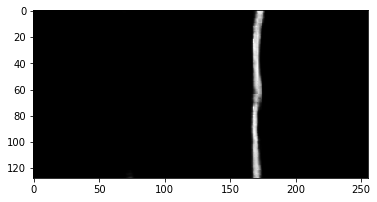

In [49]:
plt.figure()
plt.imshow(p[100],cmap='gray')

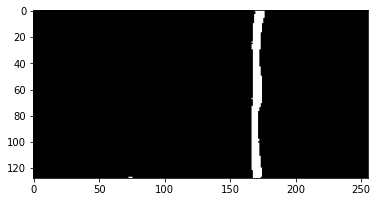

In [50]:
plt.figure()
plt.imshow(p[100]>0.03,cmap='gray')

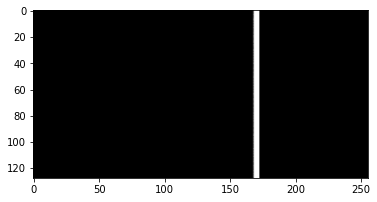

In [51]:
plt.figure()
plt.imshow(vsValY[100], cmap='gray')

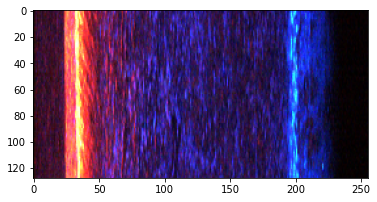

In [52]:
plt.figure()

plt.imshow(vsValX[100])